In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive/Transformer-master/

/content/drive/My Drive/Transformer-master


# ライブラリ読み込み

In [3]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.6
!pip install japanize_matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [4]:
import numpy as np
import os
import time
import MeCab

import preprocess_utils
import model
import weight_utils

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

2.3.0


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# 日英翻訳データ ダウンロード

In [5]:
# !wget http://www.manythings.org/anki/jpn-eng.zip
# !unzip ./jpn-eng.zip

# データ読み込み

In [6]:
dataset = preprocess_utils.CreateData(
    corpus_path = './jpn.txt',
    do_shuffle=True,
    seed_value=123,
    split_percent=0.95 # 学習データの割合
)

train_source, train_target, test_source, test_target, train_licence, test_licence = dataset.split_data()

print('**** Amount of data ****')
print('train_source： ', len(train_source))
print('train_target： ', len(train_target))
print('test_source： ', len(test_source))
print('test_target： ', len(test_target))
print('\n')
print('**** Train data example ****')
print('Source Example： ', train_source[0])
print('Target Example： ', train_target[0])
print('Licence： ', train_licence[0])
print('\n')
print('**** Test data example ****')
print('Source Example： ', test_source[0])
print('Target Example： ', test_target[0])
print('Licence： ', test_licence[0])

**** Amount of data ****
train_source：  52857
train_target：  52857
test_source：  2782
test_target：  2782


**** Train data example ****
Source Example：  Look after Tom.
Target Example：  トムの面倒を見てて。
Licence：  CC-BY 2.0 (France) Attribution: tatoeba.org #2782602 (CK) & #2125677 (bunbuku)



**** Test data example ****
Source Example：  You should tell your mother as soon as possible.
Target Example：  できるだけ早く、お母さんに知らせたほうがいい。
Licence：  CC-BY 2.0 (France) Attribution: tatoeba.org #3554418 (CK) & #3553337 (arnab)



# 前処理

In [7]:
BATCH_SIZE = 64 # バッチサイズ
MAX_LENGTH = 60 # シーケンスの長さ
USE_TPU = True # TPUを使うか
BUFFER_SIZE = 50000

In [8]:
train_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = train_source,
    target_data = train_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = False,
    train_dataset = None,
)

train_dataset.preprocess_data()

In [9]:
test_dataset = preprocess_utils.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = test_source,
    target_data = test_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = True,
    train_dataset = train_dataset
)

test_dataset.preprocess_data()

# バッチ作成

In [10]:
if USE_TPU:
  tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
  tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
  tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)    
  strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

trainset = tf.data.Dataset.from_tensor_slices((train_dataset.source_vector, train_dataset.target_vector))
trainset = trainset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

if USE_TPU:
  trainset = strategy.experimental_distribute_dataset(trainset)

INFO:tensorflow:Initializing the TPU system: grpc://10.79.199.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.199.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [11]:
if USE_TPU:
  PREDICT_BATCH_SIZE = 8
  testset = tf.data.Dataset.from_tensor_slices((test_dataset.source_vector, test_dataset.target_vector))
  testset = testset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=50000).batch(PREDICT_BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  testset = testset.take(1)
  testset = strategy.experimental_distribute_dataset(testset)

# モデル定義

In [12]:
num_layers=4 # レイヤー数
d_model=64 # 中間層の次元数
num_heads=4 # Multi Head Attentionのヘッド数
dff=2048 # Feed Forward Networkの次元数
dropout_rate = 0.1 # ドロップアウト率

source_vocab_size = max(train_dataset.source_token.values()) + 1 # source文の語彙数
target_vocab_size = max(train_dataset.target_token.values()) + 1 # target文の語彙数

In [13]:
# 重み初期化
def initialize_weight(checkpoint_path, optimizer, transformer, max_length, batch_size, use_tpu=False):

  if os.path.exists(checkpoint_path+'.pkl'):
    if use_tpu:
      number_of_tpu_cores = tpu_cluster_resolver.num_accelerators()['TPU']
      initialize_source, initialize_target = [[1]*max_length]*number_of_tpu_cores, [[1]*max_length]*number_of_tpu_cores
      initialize_set = tf.data.Dataset.from_tensor_slices((initialize_source, initialize_target))
      initialize_set = initialize_set.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))
          ).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size).prefetch(
              buffer_size=tf.data.experimental.AUTOTUNE
          )
      initialize_set = strategy.experimental_distribute_dataset(initialize_set)

      for inp, tar in initialize_set:
          distributed_train_step(inp, tar)

    else:
      initialize_set = tf.ones([batch_size, max_length], tf.int64)
      train_step(initialize_set, initialize_set)
    
    try:
      weight_utils.load_weights_from_pickle(checkpoint_path, optimizer, transformer)
    except:
      print('Failed to load checkpoints.')

  else:
    print('No available checkpoints.')

# 予測

In [14]:
%%time
with strategy.scope():
  # Transformer
  transformer = model.Transformer(num_layers, d_model, num_heads, dff,
                            source_vocab_size, target_vocab_size, 
                            pe_input=source_vocab_size, 
                            pe_target=target_vocab_size,
                            rate=dropout_rate)

  # Learning Rate
  learning_rate = model.CustomSchedule(d_model)

  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                      epsilon=1e-9)

  # Loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  # Loss Function
  def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

  # Metrics
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  # Checkpoint
  checkpoint_path = "/content/drive/My Drive/Transformer-master/checkpoints/tpu/model"

  def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
      predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

  @tf.function
  def distributed_train_step(X, y):
    per_replica_losses = strategy.experimental_run_v2(train_step, args=(X, y))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

  def test_step(inp, tar):
      enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar)
      
      predictions, attention_weights = transformer(inp, tar, 
                                  False, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      
      predicted_id = tf.cast(tf.argmax(predictions[: ,-1:, :], axis=-1), tf.int64)
      return inp, tf.concat([tar, predicted_id], axis=-1), attention_weights

  @tf.function
  def distributed_test_step(X, y):
        return strategy.experimental_local_results(strategy.run(test_step, args=(X, y)))


  # Initialize Weight
  initialize_weight(checkpoint_path, optimizer, transformer, MAX_LENGTH, PREDICT_BATCH_SIZE, use_tpu=USE_TPU)

  for inp, tar in testset:
    for i in range(MAX_LENGTH):
        inp, tar, attn = distributed_test_step(inp, tar)[0]

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_step at 0x7f1c87d5a6a8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_step at 0x7f1c87d5a6a8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_train_step at 0x7f1c87d5a6a8>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
renamed to `run`


Instructions for updating:
renamed to `run`


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f1c87d5a620>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f1c87d5a620>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function train_step at 0x7f1c87d5a620>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Load checkpoints successfully.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_step at 0x7f1c87d5a840>. Note that functions defined in certain environ

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_step at 0x7f1c87d5a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function distributed_test_step at 0x7f1c87d5a840>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f1c87d5a730>. Note that functions defined in certain environments, like the interactive Pyth

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f1c87d5a730>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function test_step at 0x7f1c87d5a730>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


CPU times: user 2min 47s, sys: 7.51 s, total: 2min 54s
Wall time: 4min 53s


In [15]:
def plot_attention_weight(sentence, attention, result):
  fig = plt.figure(figsize=(16, 8))

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(result.shape[0]))
    
    ax.set_ylim(result.shape[0]-1.5, -0.5)
        
    tmp_list = []
    for i in sentence:
      try:
        tmp_list.append(train_dataset.source_index[i.numpy()])
      except:
        pass

    ax.set_xticklabels(tmp_list, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([train_dataset.target_index[i.numpy()] for i in result 
                        if i < max(train_dataset.target_token.values()) - 1], 
                        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

Input: Now that he is old , it is your duty to look after him .
Output: 彼はもう高齢ですから、世話をするのはあなたの務めなのです。


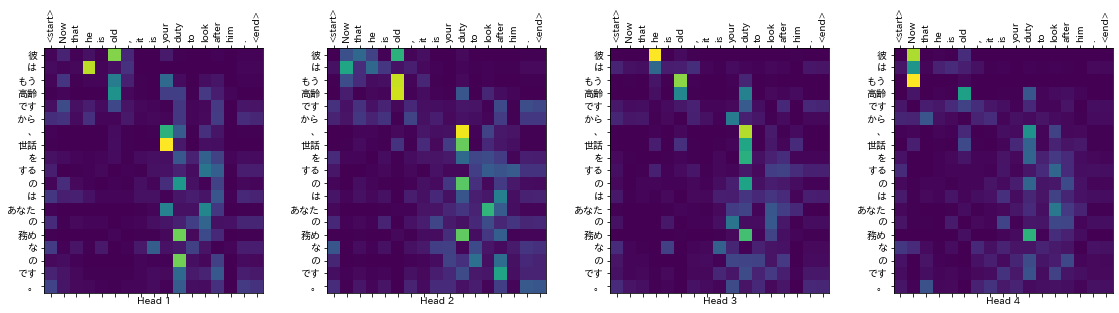

Input: He got through with his work .
Output: 彼は仕事を終えた。


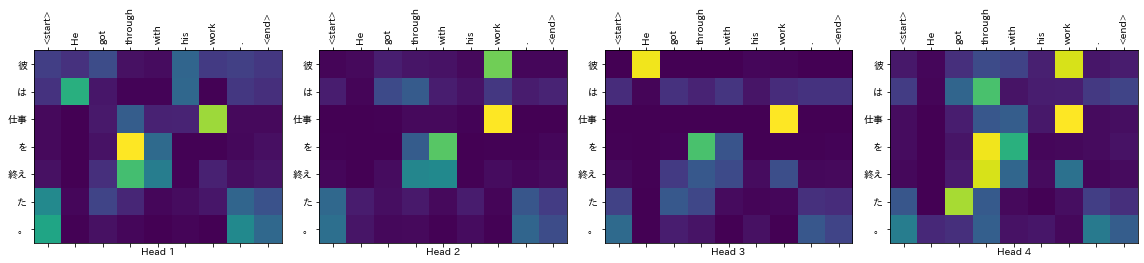

Input: Nobody can do two things at once .
Output: ２つのことを同時にすることができる人はいない。


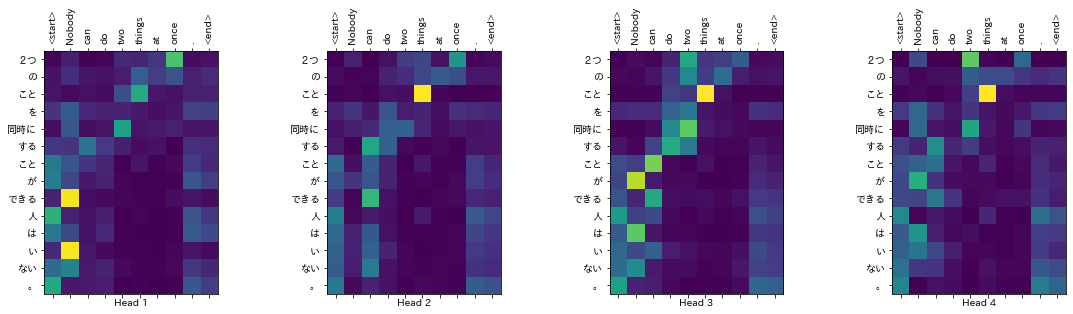

Input: Either way is fine with me .
Output: どちらにしても大丈夫だよ。


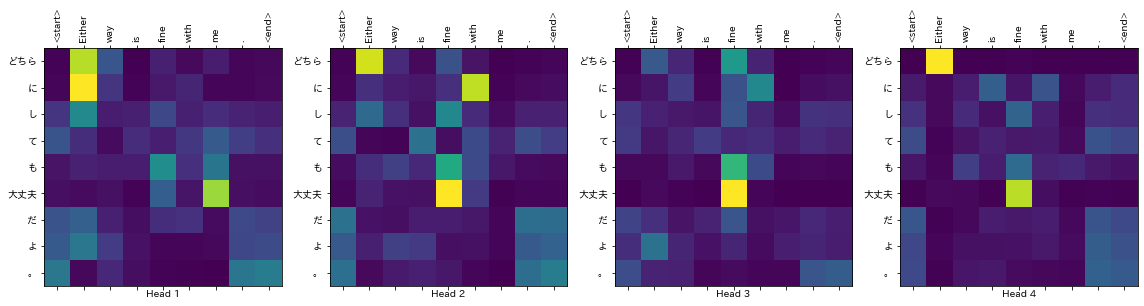

Input: Tom is in his mid thirties .
Output: トムは３０代半ばだよ。


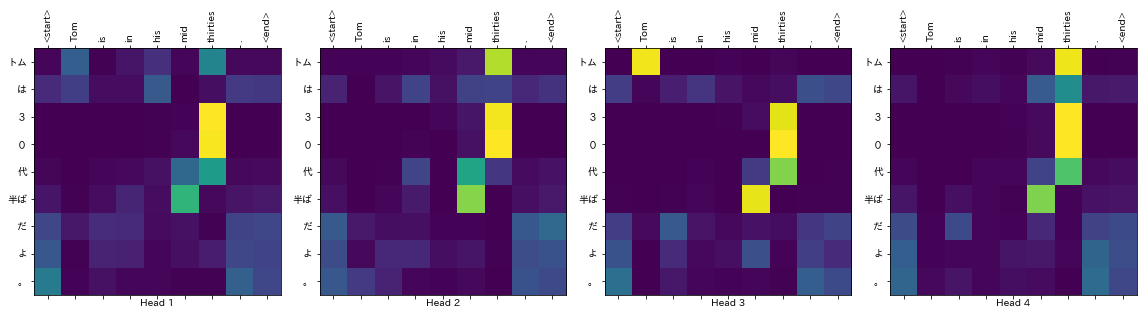

Input: It has snowed for two days .
Output: ２日間雪が降りました。


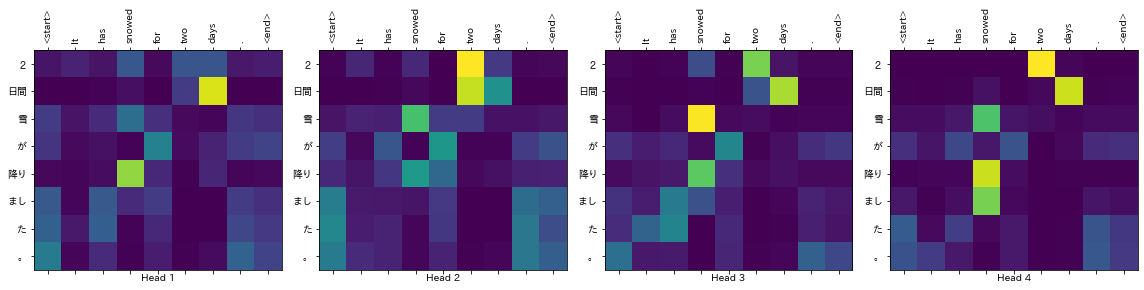

Input: Tom started talking to his girlfriend about breaking up .
Output: トムは彼女に


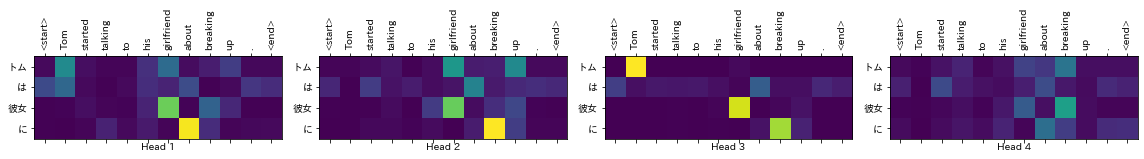

Input: They are very big apples .
Output: それはとても大きなりんごなんです。


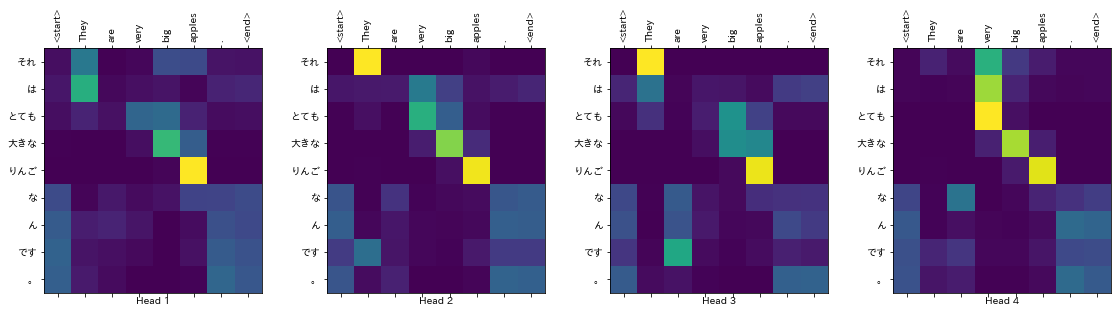

In [16]:
for i, (s, t, a) in enumerate(zip(inp.values, tar.values, attn['decoder_layer4_block2'].values)):
  sentence = tf.squeeze(s)[:tf.argmax(tf.squeeze(s)).numpy()+1]
  attention = a[0,:, :, :sentence.shape[0]]
  result = tf.squeeze(t)[:tf.argmax(tf.squeeze(t)).numpy()+1][1:]
  print("Input:", ' '.join([train_dataset.source_index[i.numpy()] for i in sentence][1:-1]))
  print("Output:", ''.join([train_dataset.target_index[i.numpy()] for i in result][:-1]))
  plot_attention_weight(sentence, attention, result)